# Livestock Heat Stress


In [ ]:
%%capture
!pip install netcdf4 colorcet zarr gcsfs cftime nc-time-axis 
import os, fnmatch, numpy as np, pandas as pd, xarray as xr
import cv2; from google.colab.patches import cv2_imshow
import pylab as plt, plotly.express as px, colorcet as cc
from matplotlib.gridspec import GridSpec
from matplotlib.colors import from_levels_and_colors
%matplotlib inline
#!apt-get -qq install libgeos-dev
#!pip install -qq https://github.com/matplotlib/basemap/archive/master.zip
#from mpl_toolkits.basemap import Basemap, maskoceans

import gcsfs; import zarr
gcs = gcsfs.GCSFileSystem( token = 'anon' )
from google.colab import drive; drive.mount( '/content/drive' )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········


In [ ]:
import numpy as np
import pylab as plt
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap, maskoceans

In [1]:
### helper functions ###
def calcRH(qair, temp, press = 1013.25):
    ### calc's RH (%) based on specific humidity and near surface temperture ###
    e = qair * press / ( 0.378 * qair + 0.622 )
    es =  6.112 * np.exp( ( 17.67 * temp )/( temp + 243.5 ) )
    rh = e / es
    rh[rh > 1] = 1
    rh[rh < 0] = 0
    return rh * 100

def calcRH_dp(t_air_c, t_air_dp):
    return 100*(np.exp((17.625*t_air_dp)/(243.04+t_air_dp))/np.exp((17.625*t_air_c)/(243.04+t_air_c))) 

from geopy.geocoders import Nominatim # uses the 'Nominatim' database to find lat and lon of cities
def cityfind(input_city_name): 
    geolocator = Nominatim(user_agent="test_agent").geocode('{0}'.format(input_city_name))
    return [geolocator.latitude, geolocator.longitude]

def rgb2hex(rgbstring): 
    s = rgbstring.split('(')[1].split(',')
    return f"#{max(0,min(np.int(s[0]),255))}{max(0,min(np.int(s[1]),255))}{max(0,min(np.int(s[2].split(')')[0]),255))}"

In [ ]:
100*(EXP((17.625*TD)/(243.04+TD))/EXP((17.625*T)/(243.04+T))) 

In [ ]:
calcRH_dp(30, 30)

100.0

## THI Thresholds
From Lallo et al 2017.
For ruminants: normal ≤ 74; moderate 75–78; severe 79–83; very severe (emergency) ≥84.
For poultry and pigs: normal <27.8, moderate 27.8–28.8, severe 28.9–29.9 and very severe (emergency) ≥ 30.0 

In [ ]:
# From Lallo et al. 2017
def THIb(Tmax, Tmin): # Pigs
    return 0.85 * Tmax + 0.15 * Tmin

def THIl(Tmax, Tmin): # Ruminants
    return 0.60 * Tmax + 0.40 * Tmin

def THIr(Tmax, RH): # Broilers
    return (1.8 * Tmax + 32) - ((0.55 - 0.0055 * RH) * (1.8 * Tmax - 26.8))

def THIp(Tmax, RH): # Layers
    return Tmax - (0.55 - ( 0.0055 * RH)) * (T_max - 14.5) 

### From Vitali et al. 2009
def THId(T, RH): # Dairy cows
    return (1.8 * T + 32) - (0.55 - 0.0055 * RH) * ((1.8 * T + 32) - 58)


In [ ]:
THId(35, 80)

90.92999999999999

In [ ]:
THIr(35, 80)

91.018

# CMIP-6 Data on google cloud

The data catatalog is stored as a CSV file. Here we read it with Pandas.

The columns of the dataframe correspond to the CMI6 controlled vocabulary. A beginners' guide to these terms is available in [this document](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q). 

In [ ]:
### Load array of availible models that have RCP 8.5 daily maximum temeperature
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_mod = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'ssp585'")
models = df_mod.source_id.unique()

# Figure 1: THI thresholds and historical conditions

### Historical T and RH for some differnet cities

In [ ]:
model = models[6]
### near surface tasmax
dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'historical' & source_id == '{0}'".format(model))
ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
ds = ds.sel( time = slice( '2000-01-01', '2010-12-31' ) )
# select a city
city1 = cityfind('Mumbai')
if city1[1] < 0 : city1[1] = city1[1]*-1 + 180
else: pass
dsc = ds.sel( lat = slice( city1[0]-0.5, city1[0]+0.5 ) )
dsc = dsc.sel( lon = slice( city1[1]-0.5, city1[1]+0.5 ) )
tasmax1 = dsc.tasmax.values[:,0,0].flatten() - 273.15
# select another city
city2 = cityfind('New Delhi')
if city2[1] < 0 : city2[1] = city2[1]*-1 + 180
else: pass
dsc = ds.sel( lat = slice( city2[0]-0.5, city2[0]+0.5 ) )
dsc = dsc.sel( lon = slice( city2[1]-0.5, city2[1]+0.5 ) )
tasmax2 = dsc.tasmax.values[:,0,0].flatten() - 273.15

### near surface tasmin
dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'tasmin' & experiment_id == 'historical' & source_id == '{0}'".format(model))
ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
ds = ds.sel( time = slice( '2000-01-01', '2010-12-31' ) )

dsc = ds.sel( lat = slice( city1[0]-0.5, city1[0]+0.5 ) )
dsc = dsc.sel( lon = slice( city1[1]-0.5, city1[1]+0.5 ) )
tasmin1 = dsc.tasmin.values[:,0,0].flatten() - 273.15

dsc = ds.sel( lat = slice( city2[0]-0.5, city2[0]+0.5 ) )
dsc = dsc.sel( lon = slice( city2[1]-0.5, city2[1]+0.5 ) )
tasmin2 = dsc.tasmin.values[:,0,0].flatten() - 273.15

### near surface specific humidity
dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'huss' & experiment_id == 'historical' & source_id == '{0}'".format(model))
ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
ds = ds.sel( time = slice( '2000-01-01', '2010-12-31' ) )

dsc = ds.sel( lat = slice( city1[0]-0.5, city1[0]+0.5 ) )
dsc = dsc.sel( lon = slice( city1[1]-0.5, city1[1]+0.5 ) )
huss1 = dsc.huss.values[:,0,0].flatten()

dsc = ds.sel( lat = slice( city2[0]-0.5, city2[0]+0.5 ) )
dsc = dsc.sel( lon = slice( city2[1]-0.5, city2[1]+0.5 ) )
huss2 = dsc.huss.values[:,0,0].flatten()

### Calc RH ###
rh1 = calcRH( huss1, tasmax1 )
rh2 = calcRH( huss2, tasmax2 )

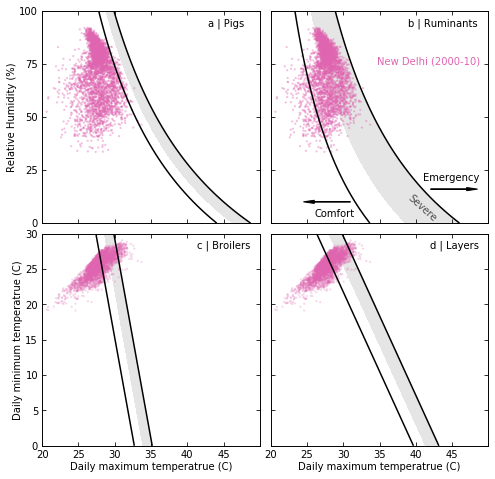

In [ ]:
plt.close('all')

pltlw = 0.8; pltfs = 10; ts = 4
plt.rcParams.update({'font.size': pltfs, 'xtick.labelsize' : pltfs, 'ytick.labelsize' : pltfs, 'legend.fontsize': pltfs, 'legend.frameon': False, 
                     'axes.linewidth':pltlw*1.2, 'xtick.major.width':pltlw, 'ytick.major.width':pltlw, 'xtick.major.size':ts, 'ytick.major.size':ts,
                     'xtick.minor.width':pltlw*0.5, 'ytick.minor.width':pltlw*0.5, 'xtick.minor.size':ts*0.5, 'ytick.minor.size':ts*0.5,
                     'xtick.bottom': True, 'xtick.top': True, 'ytick.right': True, 'ytick.right': True, 
                     'xtick.major.pad':4, 'ytick.major.pad':4, 'axes.labelpad': 2,'xtick.direction': 'in', 'ytick.direction': 'in', 
                     'legend.numpoints': 4})

fig = plt.figure( figsize = ( 8, 8 ) )
gs = gridspec.GridSpec( 2, 2 )  #, width_ratios = [0.1, 0.01, 1, 1, 1, 1, 1, 0.1]
gs.update(wspace = 0.05, hspace = 0.05)

linecolor = 'black'
### pigs ###
ax = plt.subplot( gs[0,0] )
THI_p = np.zeros( (50, 50) )
for i, T_max in enumerate(np.linspace(20,50,50)):
    for j, RH in enumerate(np.linspace(0,100,50)):
        THI_p[j,i] = THIp(T_max, RH)

plt.contour( np.linspace(20,50,50), np.linspace(0,100,50), THI_p, levels = [27.8, 29.9], colors = [linecolor] )
plt.contourf( np.linspace(20,50,50), np.linspace(0,100,50), THI_p, levels = [28.8, 29.9], colors = [linecolor], alpha =0.1 )
plt.annotate('a | Pigs', xy = (0.76,0.93), xycoords='axes fraction')
plt.xticks([20,25,30,35,40,45], [])
plt.yticks([0,25,50,75,100], [0,25,50,75,100])

#plt.scatter(tasmax1, rh1, edgecolor = 'none', facecolor = '#3690c0', alpha = 0.4, s = 5 )
#plt.scatter(tasmax2, rh2, edgecolor = 'none', facecolor = '#8c6bb1', alpha = 0.4, s = 5 )
plt.scatter(tasmax1, rh1, edgecolor = 'none', facecolor = '#df65b0', alpha = 0.4, s = 5 )

plt.xlim(20,50)
plt.ylim(0,100)
plt.ylabel('Relative Humidity (%)')

### ruminants ###
ax = plt.subplot( gs[0,1] )
THI_r = np.zeros((50,50))
for i, T_max in enumerate(np.linspace(20,50,50)):
    for j, RH in enumerate(np.linspace(0,100,50)):
        THI_r[j,i] = THIr(T_max, RH)

plt.contour( np.linspace(20,50,50), np.linspace(0,100,50), THI_r, levels = [74,84], colors = [linecolor] )
plt.contourf( np.linspace(20,50,50), np.linspace(0,100,50), THI_r, levels = [78, 84], colors = [linecolor], alpha = 0.1 )
plt.annotate('b | Ruminants', xy = (0.63,0.93), xycoords='axes fraction')
#plt.annotate('Des Moines (2000-10)', xy = (0.48,0.81), xycoords='axes fraction', color = '#3690c0')
#plt.annotate('Johannesburg (2000-10)', xy = (0.43,0.87), xycoords='axes fraction', color = '#8c6bb1')
plt.annotate('New Delhi (2000-10)', xy = (0.49,0.75), xycoords='axes fraction', color = '#df65b0')
plt.annotate('Severe', xy = (0.62, 0.01), xycoords='axes fraction', color = '#4d4d4d').set_rotation(-42)
plt.annotate('Emergency', xy = (0.7,0.2), xycoords='axes fraction') 
plt.annotate('Comfort', xy = (0.2,0.03), xycoords='axes fraction') 
plt.arrow(42, 16, 5, 0, head_width = 1.5, head_length = 1.5, color='black')
plt.arrow(31, 10, -5, 0, head_width = 1.5, head_length = 1.5, color='black')
plt.xticks([20,25,30,35,40,45], [])
plt.yticks([0,25,50,75,100], [])
plt.xlim(20,50)
plt.ylim(0,100)

#plt.scatter(tasmax1, rh1, edgecolor = 'none', facecolor = '#3690c0', alpha = 0.4, s = 5 )
#plt.scatter(tasmax2, rh2, edgecolor = 'none', facecolor = '#8c6bb1', alpha = 0.4, s = 5 )
plt.scatter(tasmax1, rh1, edgecolor = 'none', facecolor = '#df65b0', alpha = 0.4, s = 5 )

### broilers ###
ax = plt.subplot( gs[1,0] )
THI_b = np.zeros((50,50))
for i, T_max in enumerate(np.linspace(20,50,50)):
    for j, T_min in enumerate(np.linspace(0,30,50)):
        THI_b[j,i] = THIb(T_max, T_min)

plt.contour( np.linspace(20,50,50), np.linspace(0,30,50), THI_b, levels = [27.8, 29.9], colors = [linecolor] )
plt.contourf( np.linspace(20,50,50), np.linspace(0,30,50), THI_b, levels = [28.8, 29.9], colors = [linecolor], alpha = 0.1 )
plt.annotate('c | Broilers', xy = (0.71,0.93), xycoords='axes fraction')
plt.xlabel('Daily maximum temperatrue (C)')
plt.ylabel('Daily minimum temperatrue (C)')
plt.yticks([0,5,10,15,20,25,30], [0,5,10,15,20,25,30])
plt.xticks([20,25,30,35,40,45], [20,25,30,35,40,45])

#plt.scatter(tasmax1, tasmin1, edgecolor = 'none', facecolor = '#3690c0', alpha = 0.25, s = 5 )
#plt.scatter(tasmax2, tasmin2, edgecolor = 'none', facecolor = '#8c6bb1', alpha = 0.25, s = 5 )
plt.scatter(tasmax1, tasmin1, edgecolor = 'none', facecolor = '#df65b0', alpha = 0.25, s = 5 )

plt.ylim(0,30)
plt.xlim(20,50)

### layers ###
ax = plt.subplot( gs[1,1] )
THI_l = np.zeros((50,50))
for i, T_max in enumerate(np.linspace(20,50,50)): 
    for j, T_min in enumerate(np.linspace(10,30,50)): 
        THI_l[j,i] = THIl(T_max, T_min)

plt.contour( np.linspace(20,50,50), np.linspace(0,30,50), THI_l, levels = [27.8, 29.9], colors = [linecolor] )
plt.contourf( np.linspace(20,50,50), np.linspace(0,30,50), THI_l, levels = [28.8, 29.9], colors = [linecolor], alpha = 0.1 )
plt.annotate('d | Layers', xy = (0.73,0.93), xycoords='axes fraction')
plt.xlabel('Daily maximum temperatrue (C)')
plt.yticks([0,5,10,15,20,25,30], [])
plt.xticks([20,25,30,35,40,45,50], [20,25,30,35,40,45])

#plt.scatter(tasmax1, tasmin1, edgecolor = 'none', facecolor = '#3690c0', alpha = 0.25, s = 5 )
#plt.scatter(tasmax2, tasmin2, edgecolor = 'none', facecolor = '#8c6bb1', alpha = 0.25, s = 5 )
plt.scatter(tasmax1, tasmin1, edgecolor = 'none', facecolor = '#df65b0', alpha = 0.25, s = 5 )

plt.ylim(0,30)
plt.xlim(20,50)

plt.savefig( '/content/drive/My Drive/figures/livestock_heat_stress_Lallo2017.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0.02 )

# Figure 2: Map of changes in 'over threshold' days

## Projected climate data

In [ ]:
### Load array of availible models that have RCP 8.5 daily maximum temeperature
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_mod = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'ssp585'")
models = df_mod.source_id.unique()
models

array(['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1',
       'CNRM-ESM2-1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'EC-Earth3',
       'IPSL-CM6A-LR', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 'GFDL-CM4',
       'GFDL-ESM4'], dtype=object)

In [ ]:
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1','CNRM-ESM2-1', 
          'EC-Earth3-Veg', 'EC-Earth3','IPSL-CM6A-LR', 'MIROC6', 'UKESM1-0-LL',
          'MRI-ESM2-0', 'GFDL-CM4']
for model in models:

In [ ]:
models_ava = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 
          'MPI-ESM1-2-HR', 'EC-Earth3', 'EC-Earth3-Veg', 'FIO-ESM-2-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0', 
          'CESM2-WACCM', 'CESM2', 'KACE-1-0-G', 'GFDL-CM4', 'GFDL-ESM4']

In [ ]:
for model in models:
    dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'historical' & source_id == '{0}'".format(model))
    ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    print(model,  ds.lon.values[0])

BCC-CSM2-MR 0.0
CanESM5 0.0
CNRM-CM6-1-HR 0.0
CNRM-CM6-1 0.0
CNRM-ESM2-1 0.0
EC-Earth3-Veg 0.3515625
EC-Earth3 0.3515625
IPSL-CM6A-LR 0.0
MIROC6 0.0
UKESM1-0-LL 0.9375
MRI-ESM2-0 0.0
GFDL-CM4 0.625


In [ ]:
'GFDL-CM4'
model = models[-2]
### Begining of the century ###
dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'historical' & source_id == '{0}'".format(model))
ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
ds = ds.sel( time = slice( '2000-01-01', '2009-12-31' ) )
dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'huss' & experiment_id == 'historical' & source_id == '{0}'".format(model))
ds2 = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
ds2 = ds2.sel( time = slice( '2000-01-01', '2009-12-31' ) )
tasmax = ds.tasmax.values-273.15
huss = ds2.huss.values
rh = calcRH(huss, tasmax)
del huss
THI_r = THIr(tasmax, rh)
del tasmax
del rh
THI_r = np.ma.masked_where(THI_r < 84 , THI_r)
THI2010 = np.ma.count(THI_r, axis = 0) / 10
np.save('/content/drive/My Drive/data/livestock/CMIP6THIchange/{0}_2010_THIr'.format(model), THI2010)

### end of century ###
dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'ssp585' & source_id == '{0}'".format(model))
ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
ds = ds.sel( time = slice( '2090-01-01', '2099-12-31' ) )
dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'huss' & experiment_id == 'ssp585' & source_id == '{0}'".format(model))
ds2 = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
ds2 = ds2.sel( time = slice( '2090-01-01', '2099-12-31' ) )
tasmax = ds.tasmax.values-273.15
huss = ds2.huss.values
rh = calcRH(huss, tasmax)
del huss
THI_r = THIr(tasmax, rh)
del tasmax
del rh
THI_r = np.ma.masked_where(THI_r < 84 , THI_r)
THI2100 = np.ma.count(THI_r, axis = 0)/ 10
np.save('/content/drive/My Drive/data/livestock/CMIP6THIchange/{0}_2100_THIr'.format(model), THI2100)

## plot the map figure

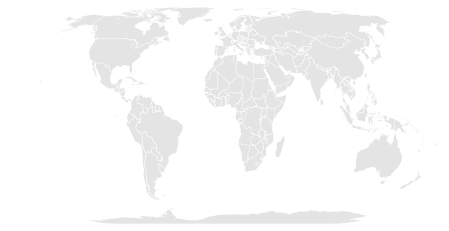

In [ ]:
plt.close('all')
fig = plt.figure( figsize = ( 8, 4 ) )
lon = np.linspace(-180, 180, 1000)
lat = np.linspace(90, -90, 500)

m = Basemap(projection = 'eck4', lon_0 = 0, resolution = 'i')
lon2d, lat2d = np.meshgrid(lon, lat)
x, y = m(lon2d, lat2d)
m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
m.fillcontinents(color = '#bdbdbd', alpha = 0.4)
m.drawcountries(color = 'white', linewidth = 0.5)

plt.savefig('/content/drive/My Drive/figures/livestock1.png', dpi=500, bbox_inches='tight', pad_inches=0)

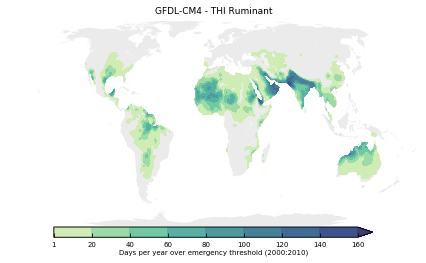

In [ ]:
plt.close('all')
fig = plt.figure( figsize = ( 8, 4 ) )

gs = gridspec.GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.2, 1, 0.2] )
gs.update(wspace = 0, hspace = 0.01)

m = Basemap(projection = 'eck4', lon_0 = 0, resolution = 'i')

v1 = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2010_THIr.npy')
v2 = v1.copy() 
n = 144 # 256 for EC-EARTH
v1[:,:n] = v2[:,n:]
v1[:,n:] = v2[:,:n]
lat = ds2.lat.values
lon = np.linspace(-180, 180, v1.shape[1])

lon2d, lat2d = np.meshgrid(lon, lat)
x, y = m(lon2d, lat2d)
v1 = maskoceans(lon2d, lat2d, v1)
colors = [rgb2hex(i) for i in px.colors.sequential.deep]
levels = [1, 20, 40, 60, 80, 100, 120, 140, 160]
cmap, norm = from_levels_and_colors(levels=levels, colors=colors[1:10], extend = 'max')

ax1 = plt.subplot(gs[0,0:3])
m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
m.fillcontinents(color = '#bdbdbd', alpha = 0.3)
m.contourf(x, y, v1, levels = levels, extend = 'max', cmap = cmap, zorder=10)
plt.title('%s - THI Ruminant'%(model), fontsize=8)

ax2 = plt.subplot( gs[1,1] )
CB = plt.colorbar( cax = ax2, orientation = "horizontal" )
CB.ax.tick_params( labelsize = 7 )
CB.set_label('Days per year over emergency threshold (2000:2010)', fontsize=7)

plt.savefig('/content/drive/My Drive/figures/{0}_THIr_2000-2010.png'.format(model), dpi=500, bbox_inches='tight', pad_inches=0)

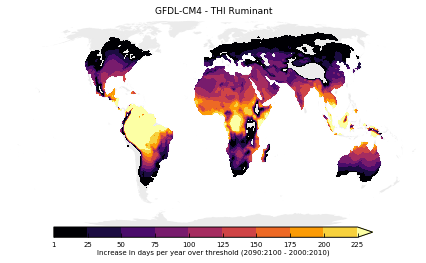

In [ ]:
plt.close('all')
fig = plt.figure( figsize = ( 8, 4 ) )

gs = gridspec.GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.2, 1, 0.2] )
gs.update(wspace = 0, hspace = 0.01)

m = Basemap(projection = 'eck4', lon_0 = 0, resolution = 'i')

v1 = THI2100 - THI2010
v2 = v1.copy() 
n = 144 # 256 for EC-EARTH
v1[:,:n] = v2[:,n:]
v1[:,n:] = v2[:,:n]
lat = ds2.lat.values
lon = np.linspace(-180, 180, v1.shape[1])

lon2d, lat2d = np.meshgrid(lon, lat)
x, y = m(lon2d, lat2d)
v1 = maskoceans(lon2d, lat2d, v1)
colors = [rgb2hex(i) for i in px.colors.sequential.deep]
colors = px.colors.sequential.Inferno
levels = [1, 25, 50, 75, 100, 125, 150, 175, 200, 225]
cmap, norm = from_levels_and_colors(levels=levels, colors=colors[:], extend = 'max')

ax1 = plt.subplot(gs[0,0:3])
m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
#m.drawcoastlines(linewidth = 0.3, color = 'black', zorder = 11)
#m.drawcountries(linewidth = 0.2, color = 'black', zorder = 11)
m.fillcontinents(color = '#bdbdbd', alpha = 0.3)
m.contourf(x, y, v1, levels = levels, extend = 'max', cmap = cmap, zorder=10)
plt.title('%s - THI Ruminant'%(model), fontsize=9)

ax2 = plt.subplot(gs[1,1])
CB = plt.colorbar(cax = ax2, orientation = "horizontal")
CB.ax.tick_params(labelsize=7)
CB.set_label('Increase in days per year over threshold (2090:2100 - 2000:2010)', fontsize=7)

plt.savefig('/content/drive/My Drive/figures/{0}_THIr_change_rcp85.png'.format(model), dpi=500, bbox_inches='tight', pad_inches=0)

## loop through all models

In [ ]:
dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'historical' & source_id == '{0}'".format('UKESM1-0-LL'))
ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
ds

In [ ]:
models = ['UKESM1-0-LL']
for model in models: 
    ### Begining of the century ###
    dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'historical' & source_id == '{0}'".format(model))
    ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds = ds.sel( time = slice( '2000-01-01', '2009-12-31' ) )
    dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'huss' & experiment_id == 'historical' & source_id == '{0}'".format(model))
    ds2 = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds2 = ds2.sel( time = slice( '2000-01-01', '2009-12-31' ) )
    tasmax = ds.tasmax.values-273.15
    huss = ds2.huss.values
    rh = calcRH(huss, tasmax)
    del huss
    THI_r = THIr(tasmax, rh)
    del tasmax
    del rh
    THI_r = np.ma.masked_where(THI_r < 84 , THI_r)
    THI2010 = np.ma.count(THI_r, axis = 0) / 10

    ### end of century ###
    dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'ssp585' & source_id == '{0}'".format(model))
    ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds = ds.sel( time = slice( '2090-01-01', '2099-12-31' ) )
    dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'huss' & experiment_id == 'ssp585' & source_id == '{0}'".format(model))
    ds2 = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds2 = ds2.sel( time = slice( '2090-01-01', '2099-12-31' ) )
    tasmax = ds.tasmax.values-273.15
    huss = ds2.huss.values
    rh = calcRH(huss, tasmax)
    del huss
    THI_r = THIr(tasmax, rh)
    del tasmax
    del rh
    THI_r = np.ma.masked_where(THI_r < 84 , THI_r)
    THI2100 = np.ma.count(THI_r, axis = 0)/ 10
    
    plt.close('all')
    fig = plt.figure( figsize = ( 8, 4 ) )

    m = Basemap(projection = 'eck4', lon_0 = 0, resolution = 'i')

    v1 = THI2100 - THI2010
    v2 = v1.copy() 
    n = np.int(ds.lon.values.shape[0]/2)
    v1[:,:n] = v2[:,n:]
    v1[:,n:] = v2[:,:n]
    lat = ds2.lat.values
    lon = np.linspace(-180, 180, v1.shape[1])

    lon2d, lat2d = np.meshgrid(lon, lat)
    x, y = m(lon2d, lat2d)
    v1 = maskoceans(lon2d, lat2d, v1)
    colors = px.colors.sequential.Inferno
    levels = [1, 25, 50, 75, 100, 125, 150, 175, 200, 225]
    cmap, norm = from_levels_and_colors(levels=levels, colors=colors[:], extend = 'max')

    m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
    m.fillcontinents(color = '#bdbdbd', alpha = 0.3)
    m.contourf(x, y, v1, levels = levels, extend = 'max', cmap = cmap, zorder=10)
    plt.title('%s - THI Ruminant'%(model), fontsize=8)

    plt.savefig('/content/drive/My Drive/figures/{0}_THIr_change_rcp85.png'.format(model), dpi=500, bbox_inches='tight', pad_inches=0)

## Bivariate with animal density

In [ ]:
### Cattle Density data from FAO ###
img = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/6_Ct_2010_Aw.tif', cv2.IMREAD_UNCHANGED)
area = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/8_Areakm.tif', cv2.IMREAD_UNCHANGED)
img = img / area
img = np.flip(img, axis=0)
v1 = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2100_THIr.npy')
v2 = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2010_THIr.npy')
v1 = v1-v2
v2 = v1.copy() 
n = 144
v1[:,:n] = v2[:,n:]
v1[:,n:] = v2[:,:n]
v1 = cv2.resize(v1, (img.shape[1], img.shape[0])) 

new = np.zeros_like(v1)
new[ ( img < 1 ) & ( v1 < 1 ) ] = 1
new[ ( img < 10 ) & ( img > 1 ) & ( v1 < 1 ) ] = 3
new[ ( img > 10 ) & ( v1 < 1 ) ] = 5

new[ ( img < 1 ) & ( v1 < 50 ) & ( v1 > 1 ) ] = 7
new[ ( img < 10 ) & ( img > 1 ) & ( v1 < 50 ) & ( v1 > 1 ) ] = 9
new[ ( img > 10 ) & ( v1 < 50 ) & ( v1 > 1 ) ] = 11

new[ ( img < 1 ) & ( v1 > 50 ) ] = 13
new[ ( img < 10 ) & ( img > 1 ) & ( v1 > 50 ) ] = 15
new[ ( img > 10 ) & ( v1 > 50 ) ] = 17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

overflow encountered in true_divide



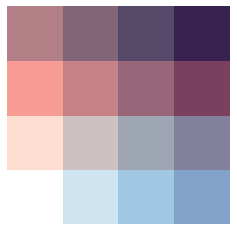

In [ ]:
### 4x4 bivariate colormap ###
reds  = [ '#ffffff', '#fcbba1', '#ef3b2c', '#67000d']
blues = [ '#ffffff', '#9ecae1', '#4292c6', '#084594' ]
### convert to rgb ###
reds  = [ tuple( int(h.strip('#')[i:i+2], 16) for i in (0, 2, 4) ) for h in reds ]
blues = [ tuple( int(h.strip('#')[i:i+2], 16) for i in (0, 2, 4) ) for h in blues ]
bicolor = []
for i in blues:
    for j in reds:
        bicolor.append( tuple( np.mean( (i,j), axis = 0, dtype = int ) ) )
bicolor = [ '#{0:02x}{1:02x}{2:02x}'.format( i[0], i[1], i[2] ) for i in bicolor ]

levels = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
cmap, norm = from_levels_and_colors( levels = levels, colors = bicolor )

fig = plt.figure( figsize = ( 4, 4 ) )
x = np.array( [[7,15,23,31],[5,13,21,29],[3,11,19,27],[1,9,17,25]] )
plt.pcolor(np.flip(x, axis =0), cmap = cmap)
plt.axis('off')
plt.savefig('/content/drive/My Drive/figures/rd_bu_bivariate_16.png', dpi = 600, bbox_inches='tight', pad_inches=0)

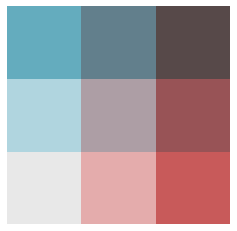

In [ ]:
#Bivaraite colormaps
colors = ['#e8e8e8', '#b0d5df', '#64acbe', '#e4acac', '#ad9ea5', '#627f8c', '#c85a5a', '#985356', '#574949'] #red blue bivariate
#colors = ['#e8e8e8', '#dfb0d6', '#be64ac', '#ace4e4', '#a5add3', '#8c62aa', '#5ac8c8', '#5698b9', '#574949'] #pink blue bivariate
levels = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
cmap, norm = from_levels_and_colors( levels = levels, colors = colors )

### to make bivarate colorbar
fig = plt.figure( figsize = ( 4, 4 ) )
x = np.array([[5,11,17],[3,9,15],[1,7,13]])
plt.pcolor(np.flip(x, axis =0), cmap = cmap)
plt.axis('off')
plt.savefig('/content/drive/My Drive/figures/rd_bu_bivariate.png', dpi = 600, bbox_inches='tight', pad_inches=0)

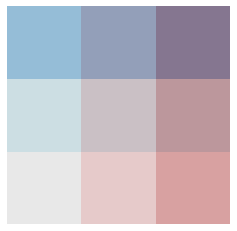

In [ ]:
reds  = [ '#e8e8e8', '#e4acac', '#c85a5a']
blues = [ '#e8e8e8', '#b0d5df', '#4292c6']
### convert to rgb ###
reds  = [ tuple( int(h.strip('#')[i:i+2], 16) for i in (0, 2, 4) ) for h in reds ]
blues = [ tuple( int(h.strip('#')[i:i+2], 16) for i in (0, 2, 4) ) for h in blues ]
bicolor = []
for i in reds:
    for j in blues:
        bicolor.append( tuple( np.mean( (i,j), axis = 0, dtype = int ) ) )

bicolor = [ '#{0:02x}{1:02x}{2:02x}'.format( i[0], i[1], i[2] ) for i in bicolor ]

levels = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
cmap, norm = from_levels_and_colors( levels = levels, colors = bicolor )

### to make bivarate colorbar
fig = plt.figure( figsize = ( 4, 4 ) )
x = np.array([[5,11,17],[3,9,15],[1,7,13]])
plt.pcolor(np.flip(x, axis =0), cmap = cmap)
plt.axis('off')
plt.savefig('/content/drive/My Drive/figures/rd_bu_bivariate.png', dpi = 600, bbox_inches='tight', pad_inches=0)

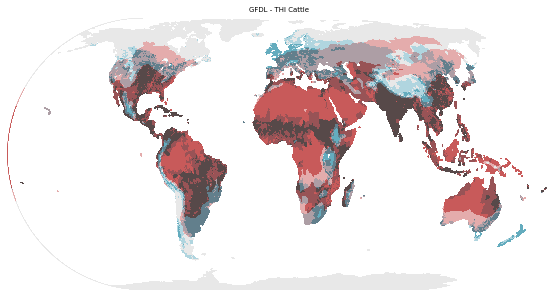

In [ ]:
plt.close('all')
fig = plt.figure( figsize = ( 10, 5 ) )

m = Basemap(projection = 'eck4', lon_0 = 0, resolution = 'l')
lat = np.linspace( -90, 90, my_arr.shape[0] )
lon = np.linspace( -180, 180, my_arr.shape[1] )

lon2d, lat2d = np.meshgrid(lon, lat)
x, y = m(lon2d, lat2d)
my_arr = maskoceans(lon2d, lat2d, new)

m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
m.pcolormesh(x, y, my_arr, cmap = cmap, zorder=10)

plt.savefig('/content/drive/My Drive/figures/{0}_THIr_change_rcp85_test.png'.format('GFDL'), dpi = 900, bbox_inches='tight', pad_inches = 0)

## Bivariate for Pigs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning:

overflow encountered in true_divide



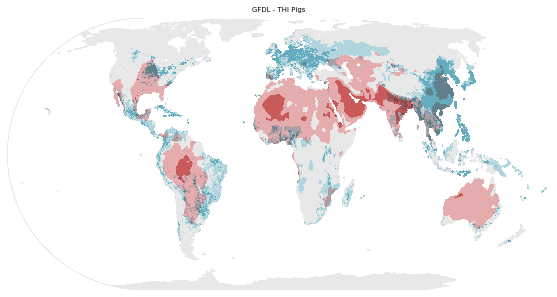

In [ ]:
models = ['GFDL-CM4']
for model in models:
    ### Begining of the century ###
    dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'historical' & source_id == '{0}'".format(model))
    ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds = ds.sel( time = slice( '2000-01-01', '2009-12-31' ) )
    dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'huss' & experiment_id == 'historical' & source_id == '{0}'".format(model))
    ds2 = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds2 = ds2.sel( time = slice( '2000-01-01', '2009-12-31' ) )
    tasmax = ds.tasmax.values-273.15
    huss = ds2.huss.values
    rh = calcRH(huss, tasmax)
    del huss
    THI_p = THIp(tasmax, rh)
    del tasmax
    del rh
    THI_p = np.ma.masked_where(THI_p < 29.99 , THI_p)
    THI2010 = np.ma.count(THI_p, axis = 0) / 10
    np.save('/content/drive/My Drive/data/livestock/CMIP6THIchange/{0}_2010_THIp'.format(model), THI2010)

    ### end of century ###
    dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'ssp585' & source_id == '{0}'".format(model))
    ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds = ds.sel( time = slice( '2090-01-01', '2099-12-31' ) )
    dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'huss' & experiment_id == 'ssp585' & source_id == '{0}'".format(model))
    ds2 = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds2 = ds2.sel( time = slice( '2090-01-01', '2099-12-31' ) )
    tasmax = ds.tasmax.values-273.15
    huss = ds2.huss.values
    rh = calcRH(huss, tasmax)
    del huss
    THI_p = THIp(tasmax, rh)
    del tasmax
    del rh
    THI_p = np.ma.masked_where(THI_p < 29.99 , THI_p)
    THI2100 = np.ma.count(THI_p, axis = 0)/ 10
    np.save('/content/drive/My Drive/data/livestock/CMIP6THIchange/{0}_2100_THIp'.format(model), THI2100)

    img = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/6_Pg_2010_Aw.tif', cv2.IMREAD_UNCHANGED)
    area = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/8_Areakm.tif', cv2.IMREAD_UNCHANGED)
    img = img / area
    img = np.flip(img, axis=0)
    v1 = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2100_THIp.npy')
    v2 = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2010_THIp.npy')
    v1 = v1-v2
    v2 = v1.copy() 
    n = 144
    v1[:,:n] = v2[:,n:]
    v1[:,n:] = v2[:,:n]
    v1 = cv2.resize(v1, (img.shape[1], img.shape[0])) 

    new = np.zeros_like(v1)
    new[ ( img < 1 ) & ( v1 < 1 ) ] = 1
    new[ ( img < 10 ) & ( img > 1 ) & ( v1 < 1 ) ] = 3
    new[ ( img > 10 ) & ( v1 < 1 ) ] = 5

    new[ ( img < 1 ) & ( v1 < 50 ) & ( v1 > 1 ) ] = 7
    new[ ( img < 10 ) & ( img > 1 ) & ( v1 < 50 ) & ( v1 > 1 ) ] = 9
    new[ ( img > 10 ) & ( v1 < 50 ) & ( v1 > 1 ) ] = 11

    new[ ( img < 1 ) & ( v1 > 50 ) ] = 13
    new[ ( img < 10 ) & ( img > 1 ) & ( v1 > 50 ) ] = 15
    new[ ( img > 10 ) & ( v1 > 50 ) ] = 17

    colors = ['#e8e8e8', '#b0d5df', '#64acbe', '#e4acac', '#ad9ea5', '#627f8c', '#c85a5a', '#985356', '#574949'] #red blue bivariate
    #colors = ['#e8e8e8', '#dfb0d6', '#be64ac', '#ace4e4', '#a5add3', '#8c62aa', '#5ac8c8', '#5698b9', '#574949'] #pink blue bivariate
    levels = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
    cmap, norm = from_levels_and_colors(levels=levels, colors=colors)

    plt.close('all')
    fig = plt.figure( figsize = ( 10, 5 ) )

    m = Basemap(projection = 'eck4', lon_0 = 0, resolution = 'l')
    lat = np.linspace( -90, 90, new.shape[0] )
    lon = np.linspace( -180, 180, new.shape[1] )

    lon2d, lat2d = np.meshgrid(lon, lat)
    x, y = m(lon2d, lat2d)
    new = maskoceans(lon2d, lat2d, new)

    m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
    m.pcolormesh(x, y, new, cmap = cmap, zorder=10)
    plt.title('{0} - THI Pigs'.format('GFDL'), fontsize=7)

    plt.savefig('/content/drive/My Drive/figures/{0}_THIr_change_rcp85_pigs.png'.format('GFDL'), dpi = 900, bbox_inches='tight', pad_inches = 0)


## Bivariate for Chickens

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning:

overflow encountered in true_divide



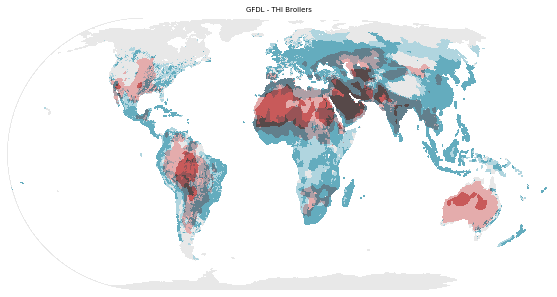

In [ ]:
models = ['GFDL-CM4']
for model in models:
    ### Begining of the century ###
    dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'historical' & source_id == '{0}'".format(model))
    ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds = ds.sel( time = slice( '2000-01-01', '2009-12-31' ) )
    dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'tasmin' & experiment_id == 'historical' & source_id == '{0}'".format(model))
    ds2 = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds2 = ds2.sel( time = slice( '2000-01-01', '2009-12-31' ) )
    tasmax = ds.tasmax.values-273.15
    tasmin = ds2.tasmin.values-273.15
    THI = THIp(tasmax, tasmin)
    del tasmax
    del tasmin
    THI = np.ma.masked_where(THI < 29.99 , THI)
    THI2010 = np.ma.count(THI, axis = 0) / 10
    np.save('/content/drive/My Drive/data/livestock/CMIP6THIchange/{0}_2010_THIb'.format(model), THI2010)

    ### end of century ###
    dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'ssp585' & source_id == '{0}'".format(model))
    ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds = ds.sel( time = slice( '2090-01-01', '2099-12-31' ) )
    dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'tasmin' & experiment_id == 'ssp585' & source_id == '{0}'".format(model))
    ds2 = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    ds2 = ds2.sel( time = slice( '2090-01-01', '2099-12-31' ) )
    tasmax = ds.tasmax.values-273.15
    tasmin = ds2.tasmin.values-273.15
    THI = THIp(tasmax, tasmin)
    del tasmax
    del tasmin
    THI = np.ma.masked_where(THI < 29.99 , THI)
    THI2100 = np.ma.count(THI, axis = 0)/ 10
    np.save('/content/drive/My Drive/data/livestock/CMIP6THIchange/{0}_2100_THIb'.format(model), THI2100)

    img = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/6_Ch_2010_Aw.tif', cv2.IMREAD_UNCHANGED)
    area = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/8_Areakm.tif', cv2.IMREAD_UNCHANGED)
    img = img / area
    img = np.flip(img, axis=0)
    v1 = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2100_THIb.npy')
    v2 = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2010_THIb.npy')
    v1 = v1-v2
    v2 = v1.copy() 
    n = 144
    v1[:,:n] = v2[:,n:]
    v1[:,n:] = v2[:,:n]
    v1 = cv2.resize(v1, (img.shape[1], img.shape[0])) 

    new = np.zeros_like(v1)
    new[ ( img < 1 ) & ( v1 < 1 ) ] = 1
    new[ ( img < 10 ) & ( img > 1 ) & ( v1 < 1 ) ] = 3
    new[ ( img > 10 ) & ( v1 < 1 ) ] = 5

    new[ ( img < 1 ) & ( v1 < 50 ) & ( v1 > 1 ) ] = 7
    new[ ( img < 10 ) & ( img > 1 ) & ( v1 < 50 ) & ( v1 > 1 ) ] = 9
    new[ ( img > 10 ) & ( v1 < 50 ) & ( v1 > 1 ) ] = 11

    new[ ( img < 1 ) & ( v1 > 50 ) ] = 13
    new[ ( img < 10 ) & ( img > 1 ) & ( v1 > 50 ) ] = 15
    new[ ( img > 10 ) & ( v1 > 50 ) ] = 17

    colors = ['#e8e8e8', '#b0d5df', '#64acbe', '#e4acac', '#ad9ea5', '#627f8c', '#c85a5a', '#985356', '#574949'] #red blue bivariate
    #colors = ['#e8e8e8', '#dfb0d6', '#be64ac', '#ace4e4', '#a5add3', '#8c62aa', '#5ac8c8', '#5698b9', '#574949'] #pink blue bivariate
    levels = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
    cmap, norm = from_levels_and_colors(levels=levels, colors=colors)


    plt.close('all')
    fig = plt.figure( figsize = ( 10, 5 ) )

    m = Basemap(projection = 'eck4', lon_0 = 0, resolution = 'l')
    lat = np.linspace( -90, 90, new.shape[0] )
    lon = np.linspace( -180, 180, new.shape[1] )

    lon2d, lat2d = np.meshgrid(lon, lat)
    x, y = m(lon2d, lat2d)
    new = maskoceans(lon2d, lat2d, new)

    m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
    m.pcolormesh(x, y, new, cmap = cmap, zorder=10)
    plt.title('{0} - THI Broilers'.format('GFDL'), fontsize=7)

    plt.savefig('/content/drive/My Drive/figures/{0}_THIr_change_rcp85_chickens.png'.format('GFDL'), dpi = 900, bbox_inches='tight', pad_inches = 0)


# Timeseries of number of animals over threshold

In [ ]:
model = 'CanESM5'
dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'tasmax' & source_id == '{1}'".format(ssp,model))
dfr

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
model = 'CanESM5'
lim = 80

### Begining of the century ###
dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == 'historical' & source_id == '{0}'".format(model))
ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
dfr = df.query("activity_id=='CMIP' & table_id == 'day' & variable_id == 'huss' & experiment_id == 'historical' & source_id == '{0}'".format(model))
ds2 = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
ds = ds.sel( time = slice( '1995-01-01', '2014-12-31' ) )
ds2 = ds2.sel( time = slice( '1995-01-01','2014-12-31' ) )
tasmax = ds.tasmax.values - 273.15
huss = ds2.huss.values
rh = calcRH(huss, tasmax)
THI_d = THId(tasmax, rh)
### Limits from Vitali 2009 ###
THI_d = THI_d - lim
THI_d = np.ma.masked_where(THI_d < 0, THI_d)
THI_d[ THI_d > 7 ] = 7
THI_d = np.sum(THI_d, axis = 0) / 20 

ssp = 'ssp245'
ssp = 'ssp585'
ssp = 'ssp126'
for ssp in ['ssp126', 'ssp245', 'ssp585']:
    ### End of the century ###
    dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == '{0}' & source_id == '{1}'".format(ssp,model))
    ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )
    dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'huss' & experiment_id == '{0}' & source_id == '{1}'".format(ssp,model))
    ds2 = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True )

    THI_df = np.zeros( ( 85, THI_d.shape[0], THI_d.shape[1] ) )
    for i, year in enumerate( range( 2015, 2100, 1) ):
        dst  = ds.sel( time = slice( '{0}-01-01'.format( year ), '{0}-12-31'.format( year ) ) )
        dst2 = ds2.sel( time = slice( '{0}-01-01'.format( year ), '{0}-12-31'.format( year ) ) )
        tasmax = dst.tasmax.values - 273.15
        huss   = dst2.huss.values
        rh   = calcRH(huss, tasmax)
        temp = THId(tasmax, rh)
        temp = temp - lim
        temp = np.ma.masked_where( temp < 0, temp )
        temp[ temp > 7 ] = 7
        THI_df[i, :, :] = np.sum( temp, axis = 0 )

    THI = THI_df - THI_d.filled( 0 )

    np.save('/content/drive/My Drive/data/livestock/CMIP6THIchange/{0}_2014_2100_yearly_THId_increase_tasmax_{1}'.format(model,ssp), THI)


In [ ]:
### Cattle Density data from FAO ###
img = cv2.imread( '/content/drive/My Drive/data/livestock/FAO_distribution/6_Ct_2010_Aw.tif', cv2.IMREAD_UNCHANGED )
img = np.flip( img, axis = 0 )
img[img<1] = 0

In [ ]:
THI85max = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2014_2100_yearly_THId_increase_tasmax_ssp585.npy')
THI45max = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2014_2100_yearly_THId_increase_tasmax_ssp245.npy')
THI85min = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2014_2100_yearly_THId_increase_tasmin_ssp585.npy')
THI45min= np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2014_2100_yearly_THId_increase_tasmin_ssp245.npy')

In [ ]:
THI85max = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/CanESM5_2014_2100_yearly_THId_increase_tasmax_ssp585.npy')
THI45max = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/CanESM5_2014_2100_yearly_THId_increase_tasmax_ssp245.npy')
THI26max = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/CanESM5_2014_2100_yearly_THId_increase_tasmax_ssp126.npy')

In [ ]:
THI85max = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2014_2100_yearly_THId_increase_tasmax_ssp585.npy')
THI45max = np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2014_2100_yearly_THId_increase_tasmax_ssp245.npy')

In [ ]:
THI.shape

(85, 180, 288)

In [ ]:
THI = THI85max
THI2 = THI.copy()
n = 144
THI[:,:,:n] = THI2[:,:,n:]
THI[:,:,n:] = THI2[:,:,:n]
del THI2
THI_rs = np.zeros((85,img.shape[0], img.shape[1]))
for i in range( 85 ): THI_rs[i,:,:] = cv2.resize(THI[i,:,:], (img.shape[1], img.shape[0])) 

risk_rate = 232.75 / 1867397.0 ## from Vitali 2009
#risk_rate = 246.73 / 1867397.0 ## from Vitali 2009
risk = img * THI_rs * risk_rate

risk85 = risk.sum(axis=(1,2))

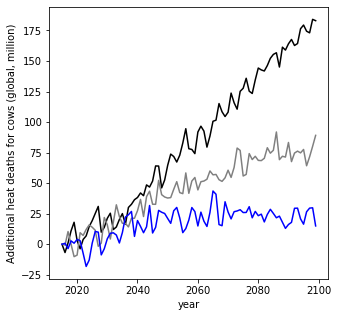

In [ ]:
fig = plt.figure( figsize = ( 5, 5 ) )
plt.plot(range( 2015, 2100, 1), risk85/1e6 - risk85[0]/1e6, color = 'black')
plt.plot(range( 2015, 2100, 1), risk45/1e6 - risk45[0]/1e6, color = 'gray')
plt.plot(range( 2015, 2100, 1), risk26/1e6 - risk26[0]/1e6, color = 'blue')
plt.ylabel('Additional heat deaths for cows (global, million)')
plt.xlabel('year')
plt.savefig('/content/drive/My Drive/figures/{0}_deaths_ssps_cow.png'.format(model), dpi = 900, bbox_inches='tight', pad_inches = 0)

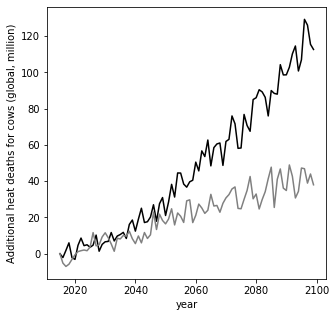

In [ ]:
fig = plt.figure( figsize = ( 5, 5 ) )
plt.plot(range( 2015, 2100, 1), risk85/1e6 - risk85[0]/1e6, color = 'black')
plt.plot(range( 2015, 2100, 1), risk45/1e6 - risk45[0]/1e6, color = 'gray')
plt.ylabel('Additional heat deaths for cows (global, million)')
plt.xlabel('year')
plt.savefig('/content/drive/My Drive/figures/{0}_deaths_ssps_cow.png'.format('GFDL'), dpi = 900, bbox_inches='tight', pad_inches = 0)

In [ ]:
THI= np.load('/content/drive/My Drive/data/livestock/CMIP6THIchange/GFDL-CM4_2014_2100_yearly_THId_increase_tasmax_ssp585.npy')
THI2 = THI.copy()
n = 144
THI[:,:,:n] = THI2[:,:,n:]
THI[:,:,n:] = THI2[:,:,:n]
del THI2
new = cv2.resize(THI[-1,:,:], (img.shape[1], img.shape[0])) 

risk_rate = 232.75 / 1867397.0 ## from Vitali 2009
new= img * new * risk_rate
new= np.ma.masked_where( new<1, new)

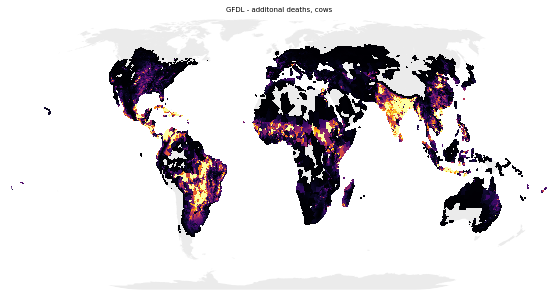

In [ ]:
plt.close('all')
fig = plt.figure( figsize = ( 10, 5 ) )

m = Basemap(projection = 'eck4', lon_0 = 0, resolution = 'l')
lat = np.linspace( -90, 90, new.shape[0] )
lon = np.linspace( -180, 180, new.shape[1] )

lon2d, lat2d = np.meshgrid(lon, lat)
x, y = m(lon2d, lat2d)
new = maskoceans(lon2d, lat2d, new)

m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
m.fillcontinents(color = '#bdbdbd', alpha = 0.3)
m.pcolormesh(x, y, new, cmap = plt.cm.inferno, vmin = 1, vmax= 500, zorder=10)
plt.title('{0} - additonal deaths, cows'.format('GFDL'), fontsize=7)

plt.savefig('/content/drive/My Drive/figures/{0}_addtional_deaths_rcp85_cows.png'.format('GFDL'), dpi = 900, bbox_inches='tight', pad_inches = 0)


# Animal density plots

In [ ]:
ans = [ 'Bf', 'Ch', 'Dk', 'Gt', 'Ho', 'Pg', 'Sh']
for an in ans:
    img = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/6_{0}_2010_Aw.tif'.format(an), cv2.IMREAD_UNCHANGED)
    area = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/8_Areakm.tif', cv2.IMREAD_UNCHANGED)
    img = img / area
    img = np.flip( img, axis = 0 )
    img = np.ma.masked_where( img < 0, img )

    colors = [rgb2hex(i) for i in px.colors.sequential.dense]
    levels = [1, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]
    levels = np.linspace(1,100,12)
    img[ img > 102 ] = 102
    cmap, norm = from_levels_and_colors(levels=levels, colors=colors, extend = 'max')
    plt.close('all')
    fig = plt.figure( figsize = ( 10, 5 ) )

    gs = gridspec.GridSpec(2, 3, height_ratios = [1, 0.05], width_ratios = [0.2, 1, 0.2] )
    gs.update(wspace = 0, hspace = 0.01)

    m = Basemap(projection = 'eck4', lon_0 = 0, resolution = 'l')

    lat = np.linspace(-90, 90, img.shape[0])
    lon = np.linspace(-180, 180, img.shape[1])
    lon2d, lat2d = np.meshgrid(lon, lat)
    x, y = m(lon2d, lat2d)
    new = maskoceans(lon2d, lat2d, new)

    ax1 = plt.subplot(gs[0,0:3])
    m.drawmapboundary(fill_color = 'white', color = 'white', linewidth = 0.0)
    m.pcolormesh(x, y, img, cmap = cmap, zorder=10)

    ax2 = plt.subplot(gs[1,1])
    CB = plt.colorbar(cax = ax2, orientation = "horizontal")
    CB.ax.tick_params(labelsize=7)
    CB.set_label('Number of animals per km$^2$', fontsize=7)

    plt.savefig('/content/drive/My Drive/figures/{0}_density.png'.format(an), dpi=700, bbox_inches='tight', pad_inches=0)

# GIS-type stuff

In [ ]:
%%capture
!pip install geopandas
!apt-get install -qq libgdal-dev libproj-dev
!pip install geoviews
import geopandas as gpd
import geoviews as gv
import geoviews.feature as gf
from cartopy import crs
gv.extension('bokeh', 'matplotlib')

In [ ]:
from shapely.geometry import Point
from geopandas.tools import sjoin
join_left_df = sjoin(pointdf, polydf, how="left")

In [ ]:
geometries = gpd.read_file('../assets/boundaries/boundaries.shp')
referendum = pd.read_csv('../assets/referendum.csv')
gdf = gpd.GeoDataFrame(pd.merge(geometries, referendum))

gv.Polygons(gdf, vdims=['name', 'leaveVoteshare']).opts(tools=['hover'], width=450, height=600, color_index='leaveVoteshare',colorbar=True, toolbar='above', xaxis=None, yaxis=None)

In [ ]:
img = cv2.imread('/content/drive/My Drive/data/livestock/FAO_distribution/6_Ct_2010_Aw.tif', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)



---


# Reference
---



In [ ]:
px.colors.sequential.swatches()

In [ ]:
model = models[6]
ssp = 'ssp585'
dfr = df.query("activity_id=='ScenarioMIP' & table_id == 'day' & variable_id == 'tasmax' & experiment_id == '{0}' & source_id == '{1}'".format(ssp, model))
ds = xr.open_zarr( gcs.get_mapper( dfr.zstore.values[0] ), consolidated = True ).sel( time = slice( '2000-01-01', '2010-12-31' ) )
ds = ds.groupby('time.year').where()

In [ ]:
for model in models:
    df_ssp = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & source_id == '%s'"%(model))
    ssps = df_ssp.experiment_id.unique()
    for ssp in ssps:
        df_fut = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '%s' & source_id == '%s'"%(ssp, model))
        mapper = gcs.get_mapper(df_fut.zstore.values[0])
        ds_fut = xr.open_zarr(mapper, consolidated=True)

        # calculate global mean
        ta_timeseries = (ds_fut.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
        # calculate yearly averages and write to numpy array
        ta_fut = ta_timeseries.values
        ta_f = np.zeros(85)
        for i in range(85): ta_f[i] = ta_fut[(i*12):(i*12)+12].mean() 

        ta = np.concatenate((ta_h, ta_f))
        dftemp = pd.DataFrame({'model': model, 'ssp': ssp, 'year': years, 'mean_tas': ta})
        allT = pd.concat((allT,dftemp))

In [ ]:
import colorlover as cl
from IPython.display import HTML
HTML(cl.to_html( cl.scales ))

In [ ]:
# Create the figure and basemap object
fig = plt.figure(figsize=(12, 6))
m = Basemap(projection='eck4', lon_0=0, resolution='c')

# Create the projection objects for the convertion
# original (Albers)
inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

# Get the target projection from the basemap object
outproj = osr.SpatialReference()
outproj.ImportFromProj4(m.proj4string)

# Convert from source projection to basemap projection
xx, yy = convertXY(xy_source, inproj, outproj)

# plot the data (first layer)
im1 = m.pcolormesh(xx, yy, data.T, cmap=plt.cm.jet)

# annotate
m.drawcountries()
m.drawcoastlines(linewidth=.5)
plt.colorbar()

In [ ]:
plt.close('all')

pltlw = 0.8; pltfs = 10; ts = 4
plt.rcParams.update({'font.size': pltfs, 'xtick.labelsize' : pltfs, 'ytick.labelsize' : pltfs, 'legend.fontsize': pltfs, 'legend.frameon': False, 
                     'axes.linewidth':pltlw*1.2, 'xtick.major.width':pltlw, 'ytick.major.width':pltlw, 'xtick.major.size':ts, 'ytick.major.size':ts,
                     'xtick.minor.width':pltlw*0.5, 'ytick.minor.width':pltlw*0.5, 'xtick.minor.size':ts*0.5, 'ytick.minor.size':ts*0.5,
                     'xtick.bottom': True, 'xtick.top': True, 'ytick.right': True, 'ytick.right': True, 
                     'xtick.major.pad':4, 'ytick.major.pad':4, 'axes.labelpad': 2,'xtick.direction': 'in', 'ytick.direction': 'in', 
                     'legend.numpoints': 4})

fig = plt.figure( figsize = ( 8, 8 ) )
gs = gridspec.GridSpec( 2, 2 )  #, width_ratios = [0.1, 0.01, 1, 1, 1, 1, 1, 0.1]
gs.update(wspace = 0.05, hspace = 0.05)

pxc = px.colors.diverging.balance
colors = [pxc[3], pxc[6], pxc[8], pxc[10]]
colors = [rgb2hex(i) for i in colors]
linecolor = 'black'

### pigs ###
ax = plt.subplot( gs[0,0] )
THI_p = np.zeros( (50, 50) )
for i, T_max in enumerate(np.linspace(20,50,50)):
    for j, RH in enumerate(np.linspace(0,100,50)):
        THI_p[j,i] = THIp(T_max, RH)

plt.contourf( np.linspace(20,50,50), np.linspace(0,100,50), THI_p, levels = [0, 27.8, 28.8, 29.9, 150], colors = colors, alpha = 0.08 )
plt.annotate('a | Pigs', xy = (0.76,0.93), xycoords='axes fraction')
plt.xticks([20,25,30,35,40,45], [])
plt.yticks([0,25,50,75,100], [0,25,50,75,100])


plt.scatter(tasmax1, rh1, edgecolor = 'none', facecolor = 'black', alpha = 0.4, s = 5 )

plt.xlim(20,50)
plt.ylim(0,100)
plt.ylabel('Relative Humidity (%)')

### ruminants ###
ax = plt.subplot( gs[0,1] )
THI_r = np.zeros((50,50))
for i, T_max in enumerate(np.linspace(20,50,50)):
    for j, RH in enumerate(np.linspace(0,100,50)):
        THI_r[j,i] = THIr(T_max, RH)

plt.contourf( np.linspace(20,50,50), np.linspace(0,100,50), THI_r, levels = [0, 74, 79, 84, 150], colors = colors, alpha = 0.08 )
plt.annotate('b | Ruminants', xy = (0.63,0.93), xycoords='axes fraction')
plt.annotate('Normal', xy = (0.2,0.04), xycoords='axes fraction', color = colors[0]) 
plt.annotate('Moderate', xy = (0.39, 0.01), xycoords='axes fraction', color = colors[1]).set_rotation(-47)
plt.annotate('Severe', xy = (0.62, 0.01), xycoords='axes fraction', color = colors[2]).set_rotation(-42)
plt.annotate('Emerg.', xy = (0.83,0.04), xycoords='axes fraction',  color = colors[3]) 

plt.xticks([20,25,30,35,40,45], [])
plt.yticks([0,25,50,75,100], [])
plt.xlim(20,50)
plt.ylim(0,100)

plt.scatter(tasmax1, rh1, edgecolor = 'none', facecolor = 'black', alpha = 0.4, s = 5 )
#plt.scatter(tasmax2, rh2, edgecolor = 'none', facecolor = '#b2df8a', alpha = 0.4, s = 5 )

### broilers ###
ax = plt.subplot( gs[1,0] )
THI_b = np.zeros((50,50))
for i, T_max in enumerate(np.linspace(20,50,50)):
    for j, T_min in enumerate(np.linspace(0,30,50)):
        THI_b[j,i] = THIb(T_max, T_min)

plt.contourf( np.linspace(20,50,50), np.linspace(0,30,50), THI_b, levels = [0, 27.8, 28.8, 29.9, 150], colors = colors, alpha = 0.08 )
plt.annotate('c | Broilers', xy = (0.71,0.93), xycoords='axes fraction')
plt.xlabel('Daily maximum temperatrue (C)')
plt.ylabel('Daily minimum temperatrue (C)')
plt.yticks([0,5,10,15,20,25,30], [0,5,10,15,20,25,30])
plt.xticks([20,25,30,35,40,45], [20,25,30,35,40,45])

plt.scatter(tasmax1, tasmin1, edgecolor = 'none', facecolor = 'black', alpha = 0.25, s = 5 )

plt.ylim(0,30)
plt.xlim(20,50)

### layers ###
ax = plt.subplot( gs[1,1] )
THI_l = np.zeros((50,50))
for i, T_max in enumerate(np.linspace(20,50,50)): 
    for j, T_min in enumerate(np.linspace(10,30,50)): 
        THI_l[j,i] = THIl(T_max, T_min)

plt.contourf( np.linspace(20,50,50), np.linspace(0,30,50), THI_l, levels = [0, 27.8, 28.8, 29.9, 150], colors = colors, alpha = 0.08 )
plt.annotate('d | Layers', xy = (0.73,0.93), xycoords='axes fraction')
plt.xlabel('Daily maximum temperatrue (C)')
plt.yticks([0,5,10,15,20,25,30], [])
plt.xticks([20,25,30,35,40,45,50], [20,25,30,35,40,45])

plt.scatter(tasmax1, tasmin1, edgecolor = 'none', facecolor = 'black', alpha = 0.25, s = 5 )

plt.ylim(0,30)
plt.xlim(20,50)

plt.savefig( '/content/drive/My Drive/figures/livestock_heat_stress_Lallo2017.png', dpi = 500, bbox_inches = 'tight', pad_inches = 0.02 )